In [1]:
import numpy
import urllib
import scipy.optimize
import random
from math import exp
from math import log
from random import shuffle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
random.seed(0)

In [3]:
def parseData(fname):
  for l in urllib.urlopen(fname):
    yield eval(l)

In [4]:

dataFile = open("C:/Users/BHEL/Desktop/Recommendation Systems/Assignment 1/winequality-white.csv")
header = dataFile.readline()
fields = ["constant"] + header.strip().replace('"','').split(';')
featureNames = fields[:-1]
labelName = fields[-1]
lines = [[1.0] + [float(x) for x in l.split(';')] for l in dataFile]
X = [l[:-1] for l in lines]
y = [l[-1] > 5 for l in lines]

def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

In [5]:
##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print "ll =", loglikelihood
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

In [8]:

X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

In [9]:
##################################################
# Train                                          #
##################################################

def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))  
  return theta

##################################################
# Predict                                        #
##################################################

def performance(theta):

  scores_test = [inner(theta,x) for x in X_test]
  predictions_test = [s > 0 for s in scores_test]
  correct_predictions = [a==b for (a,b) in zip(predictions_test,y_test)]
  ranking_df = pd.DataFrame(
    {
        "actual" : y_test,
        "predictions": predictions_test,
        "scores":scores_test,
        "correct_predictions": correct_predictions
    })
  ranking_sorted_df = ranking_df.sort_values(by=["scores"], ascending=[0])
  #acc_test = sum(correct_test) * 1.0 / len(correct_test)
  return ranking_sorted_df

def recall(k):
    result_top = result.head(k)
    total_relavant = sum(result["correct_predictions"])
    total_relavant_returned = sum(result_top["correct_predictions"])
    precision = total_relavant_returned/k
    recall_val = total_relavant_returned/total_relavant
    return precision, recall_val
    

In [10]:
##################################################
# Validation pipeline                            #
##################################################
theta = train(0.01)
result = performance(theta)
x_plot = []
y_plot = []
for k in range(1,len(y_test)):
    precision, recall_val = recall(k)
    if(k == 1):
        x_plot.insert(0,recall_val)
        y_plot.insert(0,precision)
    else:
        x_plot.append(recall_val)
        y_plot.append(precision)
    #print("k:" + str(k) + "; precision:" + str(precision) + "; recall:" + str(recall_val) )


In [16]:
x_axis = numpy.asarray(x_plot)
y_axis = numpy.asarray(y_plot)

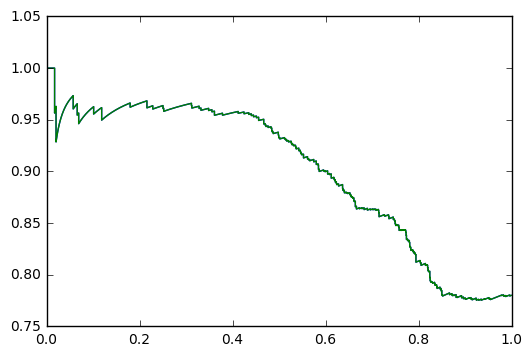

In [15]:
plt.plot(x_axis, y_axis)
plt.show()